# Probing the limits of deep learning models on synthetic DNA classification tasks
## Task 2: classify based on 6-mer motifs within 300bp sequence windows

After many unsuccessful attempts to classify _M. buryatense_ promoter sequences into 3 categories (Up, Down, No change) with respect to their genes' transcriptional repsonse to copper, we zoomed back out and designed a simulated version of this task. How much data, or how much signal, would be necessary to train a classifier up to reasonable performance on this task?

Part 1 of this analysis investigates a much simpler case: see `synthetic_DNAclassification_task1_simple.ipynb`

The analysis in Part 2 (this notebook) covers a more complex investigation into the ability of CNN models to correctly classify longer sequences (300bp windows) based on a synthetic signal of 6-mer motifs.



In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from pytorchtools import EarlyStopping

import models as m
import torch_utils as tu
from torch_utils import DatasetSpec
import utils as u
import viz as v

In [2]:
tu.set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Random seed set as 42


device(type='cuda')

### Load _M. buryatense_ expression data with 300bp upstream regions
This table includes _M. buryatense_ genes that are NOT estimated to be within an operon (the upstream genetic neighbor on the same strand is at >=120 bp away).

Key columns: 
* `locus_tag`: unique locus identifier
* `upstream_region`: 300bp genomic sequence immediately upstream of the gene's start codon. 
* condition columns (e.g. `uMax`, `lowCH4`, etc): gene expression values as the log2 ratio of the gene's measured TPM in the "High Copper" growth condition to the "No Copper" growth condition, averaged within the sample replicates in that condition. (Notice that the "NoCu" column is all 0's because the log2 of 1 = 0)

In [3]:
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,0.047594,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,0.175844,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,0.087538,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,0.032773,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,0.064979,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,0.008150,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,-0.005709,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,0.015365,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,-0.183282,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502


## Task 2. Synthetic 6-mer motif classification in 300bp seqs
### Add a score column to the dataframe

For the entire 300 bases of each upstream region:
* Calculate an average synthetic score based on `score_dict`
* If the sequence contains TATATA, give +10 score bump (simulate activating motif)
* If the sequence contains GCGCGC, give -10 score bump (simulate repressing motif)

In [4]:
# Sequence scoring system. Values are arbitrary (not 
# biologically significant) but designed to create a
# distribution centered at 0. 
score_dict = {
    'A':5,
    'C':2,
    'G':-2,
    'T':-5,
    'N':0
}

def score_seq(seq):
    '''
    Assign sequence a numerical score based on the score_dict
    and motif presence
    '''
    score = np.mean([score_dict[base] for base in seq])
    if 'TATATA' in seq:
        score += 10
    if 'GCGCGC' in seq:
        score -= 10
    return score

XYdf['score'] = XYdf['upstream_region'].apply(lambda x: score_seq(x))
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,score
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,-0.563333
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,-0.130000
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,-0.073333
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,0.220000
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,-0.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,0.383333
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,0.383333
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,-0.220000
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,-0.236667


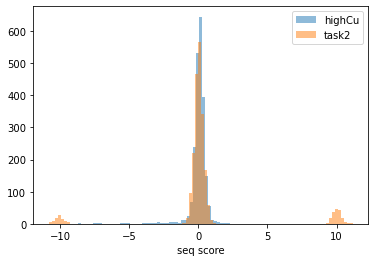

In [5]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

This synthetic score distribution (orange) somewhat approximates a realistic TPM distribution, as seen here compared to the High Copper TPM values (blues). Though notably, the synthetic distribution has two obvious peaks at either extreme, rather than a tapering off of extreme values.

Next, we formally assign each sequence a class (Up, Down, or No Change) based on the synthetic `score`.

In [6]:
# class label counts for synthetic score values
tu.set_reg_class_up_down(XYdf,'score',thresh=5)
XYdf['score_reg_UD'].value_counts()

1    1954
2     169
0      88
Name: score_reg_UD, dtype: int64

In this 6-mer synthetic scoring system, theres a little more variability between the minority classes. In the simple case (Task 1 in `synthetic_DNAclassification_task1_simple.ipynb`) the number of examples in the minority classes were similar to each other but here, there's a bit of a discrepancy: class 0 is 4% or and class 2 is 7% of the total examples. This actually reasonably reflects the minority percentages of the Up, Down, No change class labels claculated from the real HighCu column with a threshold of 0.6 (log2 ratio TPM):

In [10]:
# class label counts for HighCu data values
tu.set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
XYdf['highCu_reg_UD'].value_counts()

1    1957
2     159
0      95
Name: highCu_reg_UD, dtype: int64

In [11]:
# rename column for convenience
XYdf = XYdf.rename(columns={'score_reg_UD':'task2_class'})
XYdf.columns

Index(['og_index', 'locus_tag', 'upstream_region', 'uMax', 'lowO2_fast_growth',
       'lowCH4', 'MeOH', 'NoCu', 'medCu', 'highCu', 'lowCu',
       'highO2_slow_growth', 'NO3_lowO2_slow_growth', 'WithLanthanum',
       'NoLanthanum', 'LanzaTech', 'aa3_KO', 'crotonic_acid', 'CH4_500ppm',
       'CH4_1000ppm', 'score', 'task2_class', 'highCu_reg_UD'],
      dtype='object')

### Split the data into train and test sets
Since the classes are imbalanced (majority is Class 1 while Class 0 and Class 2 are minorities), we use StratifiedShuffleSplit to make sure the percent of examples belonging to each class is preserved between train/test splits. 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit 

# create a splitter object to just make 1 split at 80% train, 20% test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Train counts:
1    1563
2     135
0      70
Name: task2_class, dtype: int64
Test counts:
1    391
2     34
0     18
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


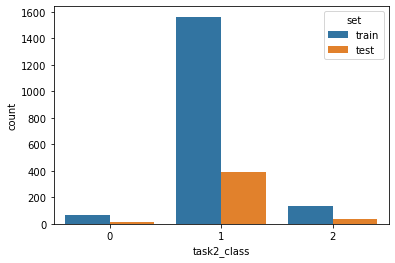

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


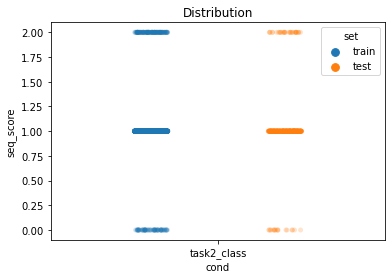

In [13]:
# class label column for synthetic analysis
target_col = 'task2_class'

# get the dataframes generated for the train/test splits 
for i, (train_idxs, test_idxs) in enumerate(sss.split(XYdf, XYdf[target_col])):
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    print(f"Train counts:\n{train_df[target_col].value_counts()}")
    print(f"Test counts:\n{test_df[target_col].value_counts()}")
    
    # a few visualizations of the class balance across splits
    v.plot_train_test_stacks(train_df, test_df, score_col=target_col)
    v.view_train_test_dist(train_df, test_df,[target_col],id_col='locus_tag')


## Load seqs into data loaders
With these splits in hand, load them into PyTorch data loaders for easy access during training

In [14]:
seq_col = 'upstream_region' # DNA seq column
target_col = 'task2_class' # class label column

# Helper wrapper for working with One-hot encoded DNA
# (instead of K-mers, for example)
dataset_types = [
    DatasetSpec('ohe'),
]

# Create dataloaders "dls" dict of PyTorch DataLoader objects
dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)

# Pull out the DataLoader objects for One-hot encoded DNA
ohe_train_dl,ohe_val_dl = dls['ohe']

View the class split across batches when the DataLoader is called. For now the sampling of examples into batches is quite imbalanced (most examples in each batch are Class 1 ("no change" class)

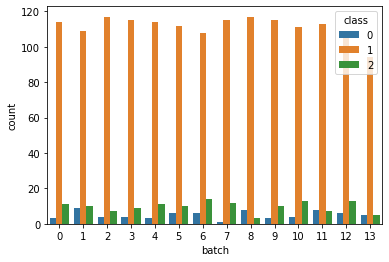

In [15]:
v.see_batch_class_dist(ohe_train_dl)

## Design CNN model
For this more complex/diluted signal, we start with a CNN model that is still simple but has bigger kernels than the one used on Task 1 since the motif is longer (6-mer instead of 3-mer). 
* It has 8 convolutional filters, with kernel size 6. 
* It has 1 hidden layer of 10 fully connected nodes
* And a final output layer where it predicts the class label (here it is 3 for the 3 classes)

In [17]:
# Model set up
cnn1_name = "6mer in mbur proms motif clsf"
model = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10,
    dropout=0
)

## Run model and collect performance stats
Set up `model_res` as a model result dictionary with various training info (epochs, validation loss, etc) and `pred_dfs` to record model predictions on various sequence sets so we can calculate model accuracy later. 

In [18]:
model_res = {} # collect 
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

E:179 | train loss:0.149 | val loss: 0.534:   4%|▎         | 179/5000 [00:18<06:53, 11.66it/s]

EarlyStopping counter: 125 out of 500


E:304 | train loss:0.037 | val loss: 0.787:   6%|▌         | 305/5000 [00:29<06:40, 11.71it/s]

EarlyStopping counter: 250 out of 500


E:429 | train loss:0.009 | val loss: 1.081:   9%|▊         | 429/5000 [00:39<06:31, 11.67it/s]

EarlyStopping counter: 375 out of 500


E:552 | train loss:0.002 | val loss: 1.346:  11%|█         | 552/5000 [00:50<06:46, 10.94it/s]


EarlyStopping counter: 500 out of 500
Early stopping


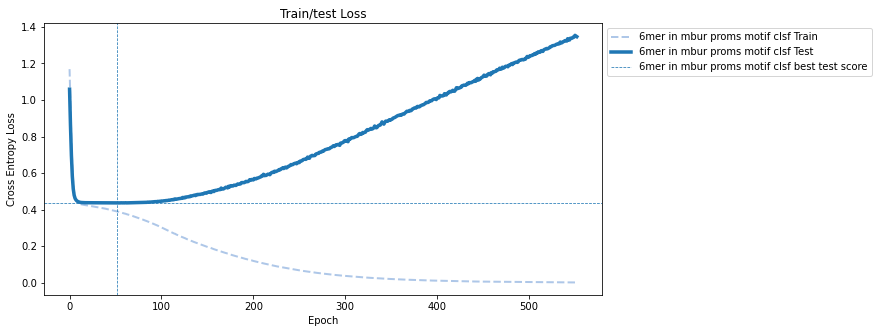

In [19]:
# train model
model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl, # M. buryatense sequence DataLoader
    ohe_val_dl, # M. buryatense sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

Here, the loss curve for the test set quickly diverges from the training set! From the confusion matrix below, we can see that the models are exclusively predicting the majority class and not learning the detect the differences between them. 

Running predictions for 6mer in mbur proms motif clsf


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


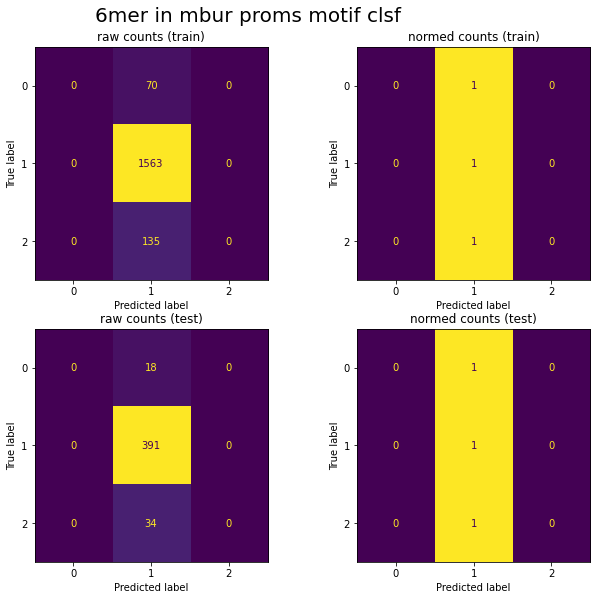

In [20]:
seq_list = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn1_name] = tu.get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn1_name]['model_name']}"
)

# Retry with a balanced sampler
The simple task in Part 1 didn't require a balanced sampler, but here let's give it a shot and see if sampling each class in equal proportion during each training epoch helps. In the plot below, we can see that the classes are sampled more evenly.

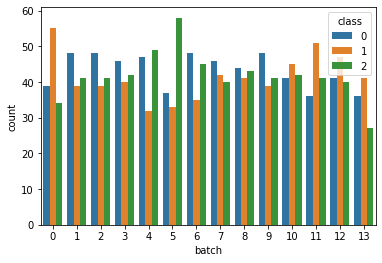

In [24]:
sampler = tu.make_weighted_sampler(train_df,target_col)
dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler, # add balanced sampler to the DataLoader
    shuffle=False
)

ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

E:192 | train loss:0.029 | val loss: 0.823:   4%|▍         | 193/5000 [00:17<07:01, 11.40it/s]

EarlyStopping counter: 125 out of 500


E:317 | train loss:0.005 | val loss: 1.105:   6%|▋         | 317/5000 [00:27<06:50, 11.41it/s]

EarlyStopping counter: 250 out of 500


E:442 | train loss:0.001 | val loss: 1.366:   9%|▉         | 443/5000 [00:38<06:39, 11.41it/s]

EarlyStopping counter: 375 out of 500


E:565 | train loss:0.000 | val loss: 1.583:  11%|█▏        | 565/5000 [00:49<06:29, 11.39it/s]


EarlyStopping counter: 500 out of 500
Early stopping


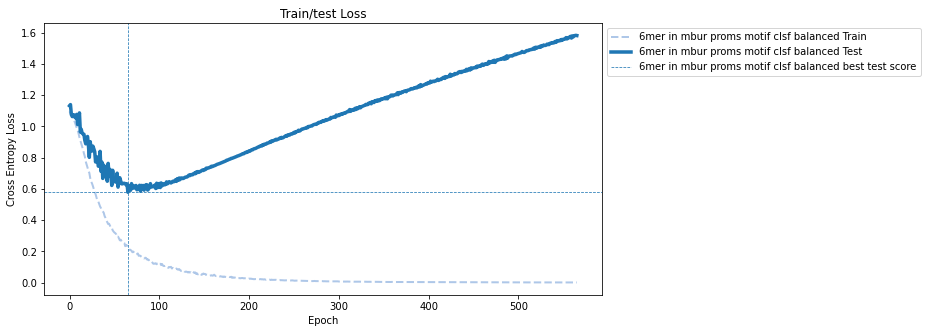

In [25]:
# Model set up
cnn2_name = "6mer in mbur proms motif clsf balanced"
model2 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10,
    dropout=0
)

# model training
model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl, # M. buryatense sequence DataLoader
    ohe_val_dl, # M. buryatense sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced


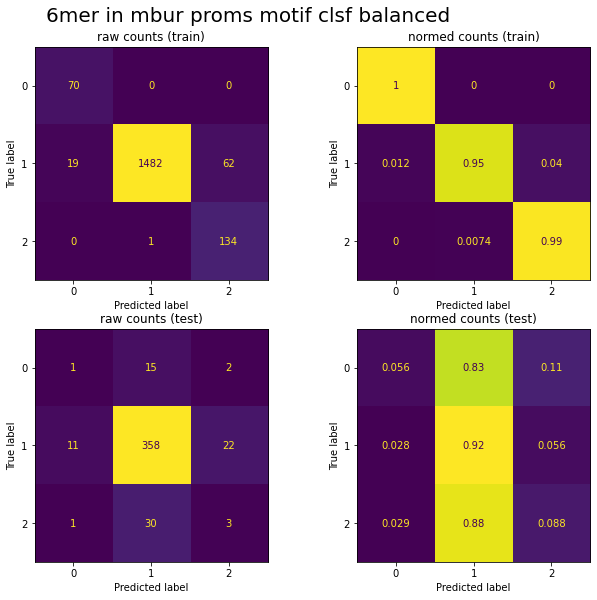

In [26]:
# model evaluation
pred_dfs[cnn2_name] = tu.get_confusion_stats(
    model_res[cnn2_name]['model'],
    model_res[cnn2_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn2_name]['model_name']}"
)

Hm, still not so good. Even rebalancing the sampler didn't prevent overfitting. At least the model can learn to memorize the training set, even though it still can't generalize to the underlying pattern on the test set. 

Is this model better than if we were to shuffle the sequences (and destroy the motifs that influenced the scoring)?

# Compare these results to shuffling the inputs sequences
Use the same class assignments for each sequences but shuffle the DNA string so that the motifs should be lost

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


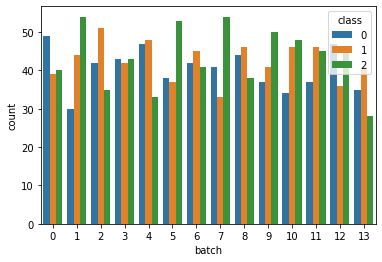

In [27]:
seq_col = 'shuffled_seq'
target_col = 'task2_class'

def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

# Add shuffled seq columns to the dataframe
train_df[seq_col] = train_df['upstream_region'].apply(lambda x: shuffle_seq(x))
test_df[seq_col] = test_df['upstream_region'].apply(lambda x: shuffle_seq(x))

# re-build the dataloaders
dls_shuff = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

ohe_train_dl_shuff,ohe_val_dl_shuff = dls_shuff['ohe']

v.see_batch_class_dist(ohe_train_dl_shuff)

E:219 | train loss:0.021 | val loss: 0.862:   4%|▍         | 220/5000 [00:19<06:58, 11.43it/s]

EarlyStopping counter: 125 out of 500


E:344 | train loss:0.004 | val loss: 1.121:   7%|▋         | 344/5000 [00:30<06:46, 11.46it/s]

EarlyStopping counter: 250 out of 500


E:469 | train loss:0.001 | val loss: 1.345:   9%|▉         | 470/5000 [00:41<06:35, 11.45it/s]

EarlyStopping counter: 375 out of 500


E:592 | train loss:0.000 | val loss: 1.548:  12%|█▏        | 592/5000 [00:52<06:27, 11.36it/s]


EarlyStopping counter: 500 out of 500
Early stopping


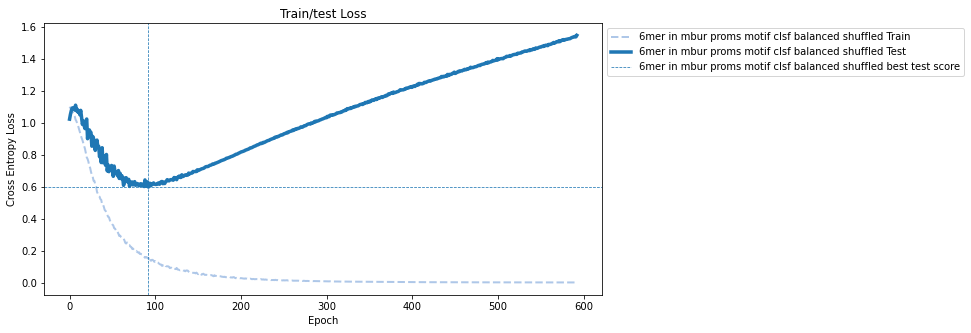

In [28]:
# Model set up
cnn3_name = "6mer in mbur proms motif clsf balanced shuffled"
model3 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10,
    dropout=0
)

# Model training
model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl_shuff, # M. buryatense sequence DataLoader
    ohe_val_dl_shuff, # M. buryatense sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='classification'
)

Running predictions for 6mer in mbur proms motif clsf balanced shuffled


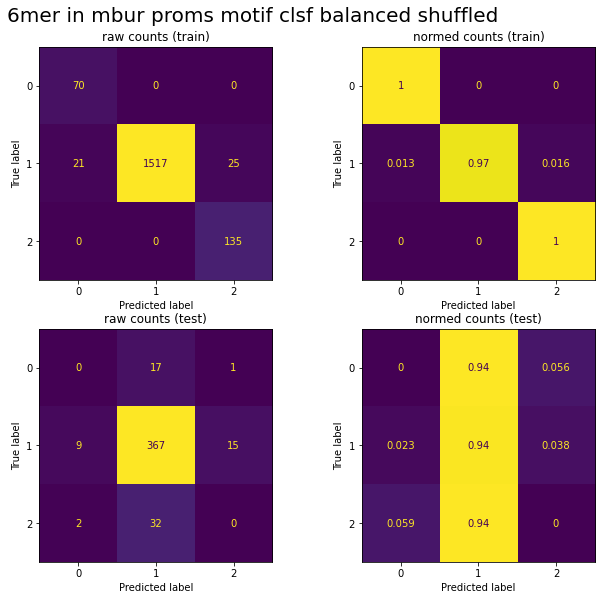

In [29]:
seq_list_shuff = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn3_name] = tu.get_confusion_stats(
    model_res[cnn3_name]['model'],
    model_res[cnn3_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn3_name]['model_name']}"
)

In [30]:
# # Check filters of Model 2?
# seqs = train_df['upstream_region'].values
# v.view_conv2D_wrapper(model2,seqs,DEVICE,act_thresh=1.0,ysc=0.25)

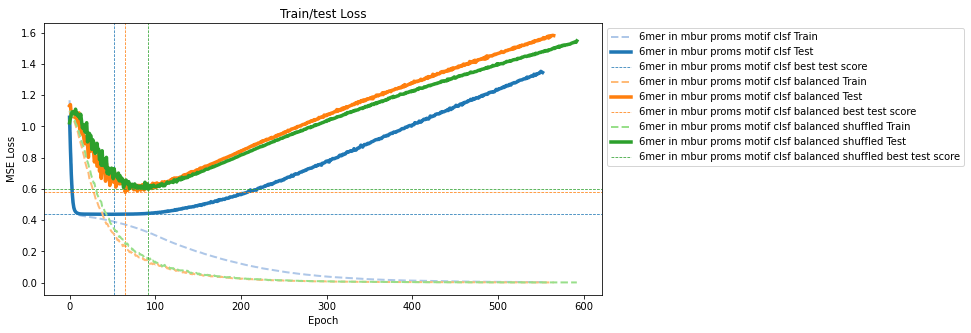

In [31]:
# Look at all the lost curves together
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

## Summary so far
So far, we don't have a model that can learn the simulated activating/repressing motif pattern. Even the model trained on shuffled versions of the input sequence isn't much different than on the original sequences from which the class labels were assigned.

In [32]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,6mer in mbur proms motif clsf,train,0.294683,0.333333,0.312819,1768
1,6mer in mbur proms motif clsf,test,0.294206,0.333333,0.312550,443
0,6mer in mbur proms motif clsf balanced,train,0.823172,0.980256,0.887750,1768
1,6mer in mbur proms motif clsf balanced,test,0.358791,0.353131,0.354880,443
0,6mer in mbur proms motif clsf balanced shuffled,train,0.870994,0.990190,0.923295,1768
1,6mer in mbur proms motif clsf balanced shuffled,test,0.294071,0.312873,0.303181,443


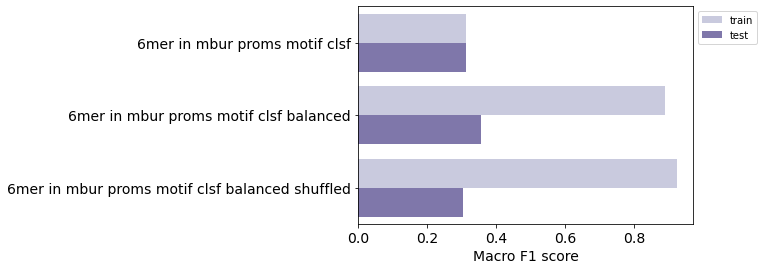

In [33]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

In this synthetic example, the models with balanced samplers are still overfitting to the training data and seemingly unable to generalize to the test data. Maybe in this case, the signal-noise is too hard to overcome with only these sequences?

To test this, instead of starting with actual _M. buryatense_ sequences, let's randomly generate a bunch and see if this improves with dataset size!

## Use more randomly generated sequences
Generate `n` random sequences of the same length (300bp) to create larger datasets than the _M. buryatense_ genome.

In [34]:
seq_length = 300
syn_seqs = []
n = 10000

with tqdm.trange(n) as pbar:
    for i in pbar:
        if i%1000 == 0:
            pbar.set_description(f"i:{i}")
        my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
        syn_seqs.append((i,my_seq))

syn_df = pd.DataFrame(syn_seqs,columns=['id','seq'])
syn_df.head()


i:9000: 100%|██████████| 10000/10000 [00:00<00:00, 11948.47it/s]


,id,seq
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...


Here is a synthetic sequence dataset. Let's score it the same way as the M. buryatense promoter dataset.

In [35]:
syn_df['score'] = syn_df['seq'].apply(lambda x: score_seq(x))
syn_df

,id,seq,score
0,0,CAACTGTCTATCATTAGAGCCAACGCACAACGTCTCTGGCATAAAG...,0.310000
1,1,GATTCTCTGCCGCTTCTACGACGTGATCTCCGGGAAGATTAATCTT...,-0.080000
2,2,GTTCCTGCTTAGAGCGTTGGGAGCAAGCATAGCGTTTGAGCATGTT...,-0.040000
3,3,AGCACTCCGCAATAGTAGAACAAGGCACATTCCCGGGCATCGGCCG...,0.260000
4,4,CTTCTAAGGCGACCGACAAAGTTCAGAAGTAATGCTCCTACCGACG...,0.040000
...,...,...,...
9995,9995,TGCATCGAGATCGTAAAAAGGTAATCATCGCCGCCGGCCATAAATT...,0.166667
9996,9996,ACAGGGTCGTCGAACACCCCAGGATGATGCCGAATTCGGCAAGGGC...,10.246667
9997,9997,AGGGCTTCACGAATCTGCGAGTGAATCCCTTTATCCAGGGTGAGCG...,-0.013333
9998,9998,CGACATAGGCGGTTATGCATCTGGGAGCCGTGGCGCAACTCTGGTT...,-0.353333


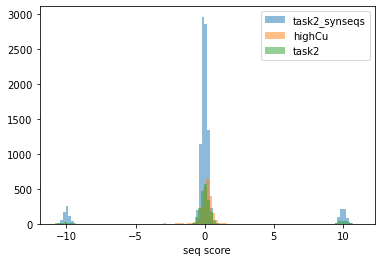

In [36]:
plt.hist(syn_df['score'],bins=100,alpha=0.5,label='task2_synseqs')
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='task2')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [37]:
# assign sequences to class labels
tu.set_reg_class_up_down(syn_df,'score',thresh=5)
syn_df['score_reg_UD'].value_counts()

1    8741
2     631
0     628
Name: score_reg_UD, dtype: int64

The spread of the distribution is about the same, but just a lot more examples in each bucket. Each minority class is about 6% of the total inputs.

In [38]:
# rename for convenience
syn_df = syn_df.rename(columns={'score_reg_UD':'task2_class'})
syn_df.columns

Index(['id', 'seq', 'score', 'task2_class'], dtype='object')

### use the same stratified splitter to create a train/test split of the bigger dataset

Train counts:
1    6993
2     505
0     502
Name: task2_class, dtype: int64
Test counts:
1    1748
0     126
2     126
Name: task2_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


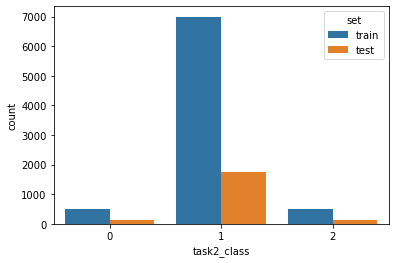

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


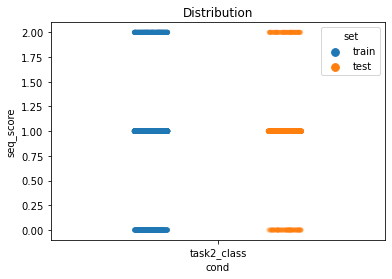

In [39]:
target_col = 'task2_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(syn_df, syn_df[target_col])):
    syn_train_df = syn_df.iloc[train_idxs]
    syn_test_df = syn_df.iloc[test_idxs]
    
    print(f"Train counts:\n{syn_train_df[target_col].value_counts()}")
    print(f"Test counts:\n{syn_test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(syn_train_df, syn_test_df, score_col=target_col)
    v.view_train_test_dist(syn_train_df, syn_test_df,[target_col],id_col='id')


## Load randomly generated seqs into data loaders

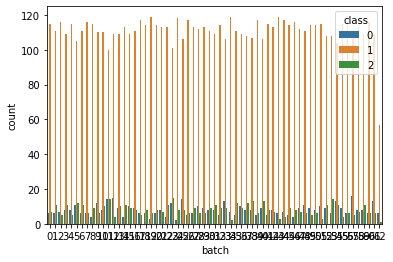

In [40]:
seq_col = 'seq'
target_col = 'task2_class'

dataset_types = [
    DatasetSpec('ohe'),
]

syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

## Train models with synthetic dataset

E:147 | train loss:0.321 | val loss: 0.568:   3%|▎         | 148/5000 [00:57<31:15,  2.59it/s]

EarlyStopping counter: 125 out of 500


E:272 | train loss:0.169 | val loss: 0.778:   5%|▌         | 273/5000 [01:45<30:22,  2.59it/s]

EarlyStopping counter: 250 out of 500


E:397 | train loss:0.059 | val loss: 1.177:   8%|▊         | 398/5000 [02:33<29:45,  2.58it/s]

EarlyStopping counter: 375 out of 500


E:522 | train loss:0.016 | val loss: 1.825:  10%|█         | 522/5000 [03:22<28:54,  2.58it/s]

EarlyStopping counter: 500 out of 500
Early stopping


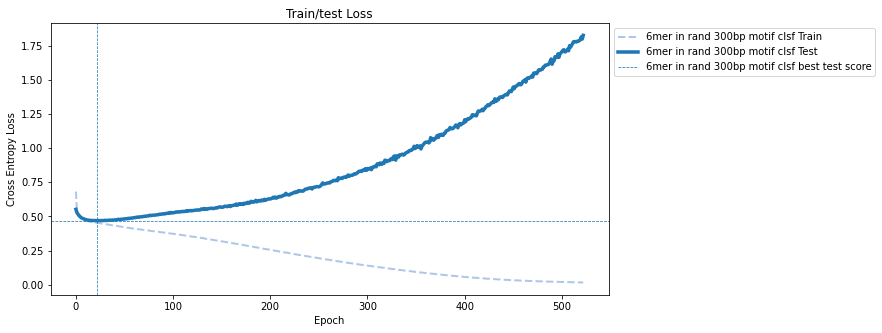

In [41]:
# Model set up
cnn5_name = "6mer in rand 300bp motif clsf"
model5 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10,
    dropout=0
)

# Model training
seq_len=len(syn_train_df[seq_col].values[0])
model_res[cnn5_name] = tu.collect_model_stats(
    cnn5_name,
    seq_len,
    syn_ohe_train_dl, # synthetic sequence DataLoader
    syn_ohe_val_dl, # synthetic sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model5,
    loss_type='classification'
)

Running predictions for 6mer in rand 300bp motif clsf


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


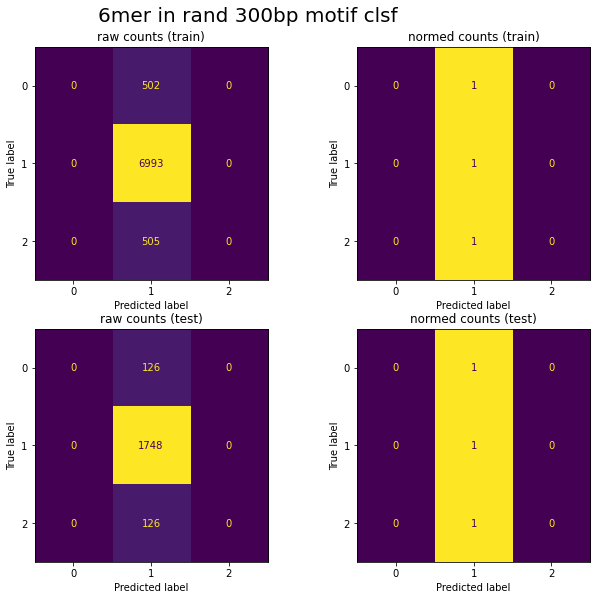

In [42]:
# Model evaluation
syn_seq_list = [
    (syn_train_df[seq_col].values,syn_train_df[target_col],"train"),
    (syn_test_df[seq_col].values,syn_test_df[target_col],"test")
]

pred_dfs[cnn5_name] = tu.get_confusion_stats(
    model_res[cnn5_name]['model'],
    model_res[cnn5_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn5_name]['model_name']}"
)

## Retry training on generated sequences with a balanced sampler

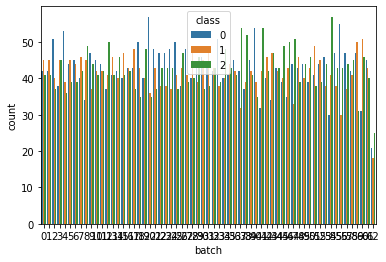

In [43]:
sampler = tu.make_weighted_sampler(syn_train_df,target_col)
syn_dls = tu.build_dataloaders(
    syn_train_df, 
    syn_test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=sampler,
    shuffle=False
)

syn_ohe_train_dl,syn_ohe_val_dl = syn_dls['ohe']

v.see_batch_class_dist(syn_ohe_train_dl)

E:177 | train loss:0.166 | val loss: 1.160:   4%|▎         | 178/5000 [01:09<31:21,  2.56it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:0.033 | val loss: 1.621:   6%|▌         | 303/5000 [01:58<30:53,  2.53it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:0.003 | val loss: 2.294:   9%|▊         | 428/5000 [02:47<29:40,  2.57it/s]

EarlyStopping counter: 375 out of 500


E:552 | train loss:0.000 | val loss: 3.163:  11%|█         | 552/5000 [03:35<28:59,  2.56it/s]

EarlyStopping counter: 500 out of 500
Early stopping


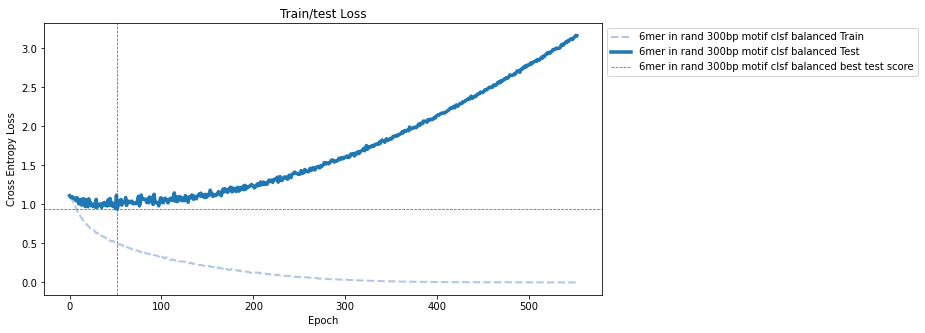

Running predictions for 6mer in rand 300bp motif clsf balanced


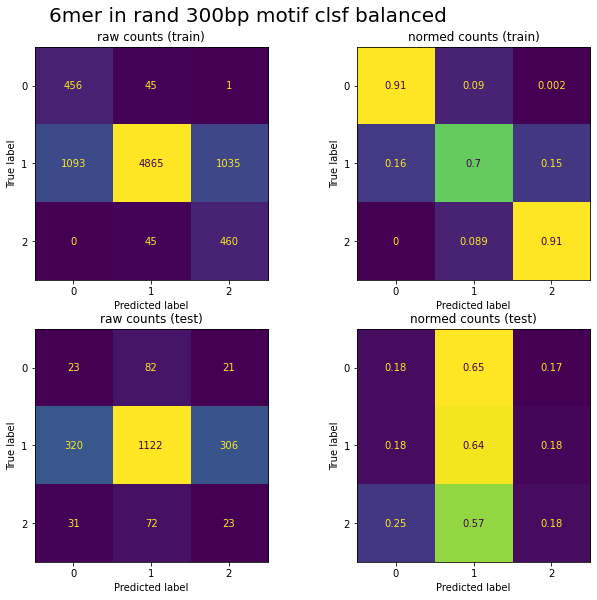

In [44]:
# Model set up
cnn6_name = "6mer in rand 300bp motif clsf balanced"
model6 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=6,
    fc_node_num=10,
    dropout=0
)

# Model training
model_res[cnn6_name] = tu.collect_model_stats(
    cnn6_name,
    seq_len,
    syn_ohe_train_dl, # synthetic sequence DataLoader
    syn_ohe_val_dl, # synthetic sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model6,
    loss_type='classification'
)

# Model evaluation
pred_dfs[cnn6_name] = tu.get_confusion_stats(
    model_res[cnn6_name]['model'],
    model_res[cnn6_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn6_name]['model_name']}"
)

Hm, still not getting there with the 10,000 seq dataset and the balanced sampler. Maybe we need a more complex model?

## Train a more complex model 
This set up comes with 2 conv layers and 2 dense layers and a conv max pooling layer

E:1588 | train loss:0.104 | val loss: 0.064:  32%|███▏      | 1589/5000 [12:53<27:41,  2.05it/s]

EarlyStopping counter: 125 out of 500


E:1963 | train loss:0.087 | val loss: 0.054:  39%|███▉      | 1964/5000 [15:55<24:31,  2.06it/s]

EarlyStopping counter: 125 out of 500


E:2806 | train loss:0.065 | val loss: 0.044:  56%|█████▌    | 2807/5000 [22:44<17:44,  2.06it/s]

EarlyStopping counter: 125 out of 500


E:2931 | train loss:0.070 | val loss: 0.038:  59%|█████▊    | 2932/5000 [23:45<16:45,  2.06it/s]

EarlyStopping counter: 250 out of 500


E:3056 | train loss:0.070 | val loss: 0.045:  61%|██████    | 3057/5000 [24:45<15:43,  2.06it/s]

EarlyStopping counter: 375 out of 500


E:3199 | train loss:0.069 | val loss: 0.044:  64%|██████▍   | 3200/5000 [25:55<14:33,  2.06it/s]

EarlyStopping counter: 125 out of 500


E:3324 | train loss:0.064 | val loss: 0.045:  66%|██████▋   | 3325/5000 [26:55<13:31,  2.06it/s]

EarlyStopping counter: 250 out of 500


E:3449 | train loss:0.064 | val loss: 0.041:  69%|██████▉   | 3450/5000 [27:56<12:30,  2.06it/s]

EarlyStopping counter: 375 out of 500


E:3576 | train loss:0.061 | val loss: 0.039:  72%|███████▏  | 3577/5000 [28:57<11:30,  2.06it/s]

EarlyStopping counter: 125 out of 500


E:3791 | train loss:0.068 | val loss: 0.040:  76%|███████▌  | 3792/5000 [30:42<09:47,  2.05it/s]

EarlyStopping counter: 125 out of 500


E:4082 | train loss:0.058 | val loss: 0.040:  82%|████████▏ | 4083/5000 [33:03<07:26,  2.05it/s]

EarlyStopping counter: 125 out of 500


E:4207 | train loss:0.057 | val loss: 0.040:  84%|████████▍ | 4208/5000 [34:04<06:24,  2.06it/s]

EarlyStopping counter: 250 out of 500


E:4332 | train loss:0.058 | val loss: 0.039:  87%|████████▋ | 4333/5000 [35:04<05:23,  2.06it/s]

EarlyStopping counter: 375 out of 500


E:4457 | train loss:0.060 | val loss: 0.039:  89%|████████▉ | 4457/5000 [36:05<04:23,  2.06it/s]

EarlyStopping counter: 500 out of 500
Early stopping


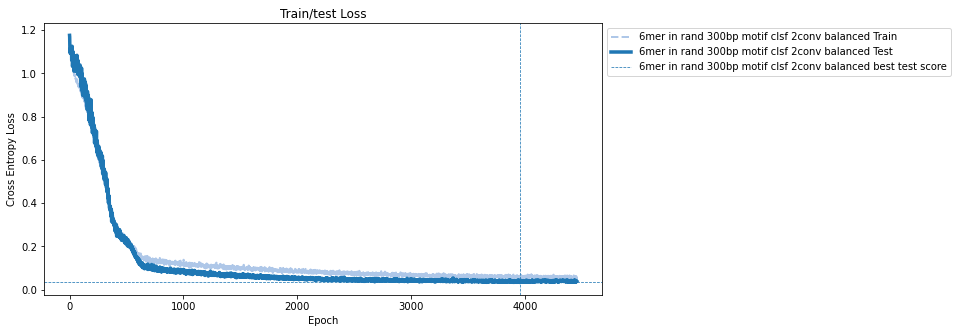

Running predictions for 6mer in rand 300bp motif clsf 2conv balanced


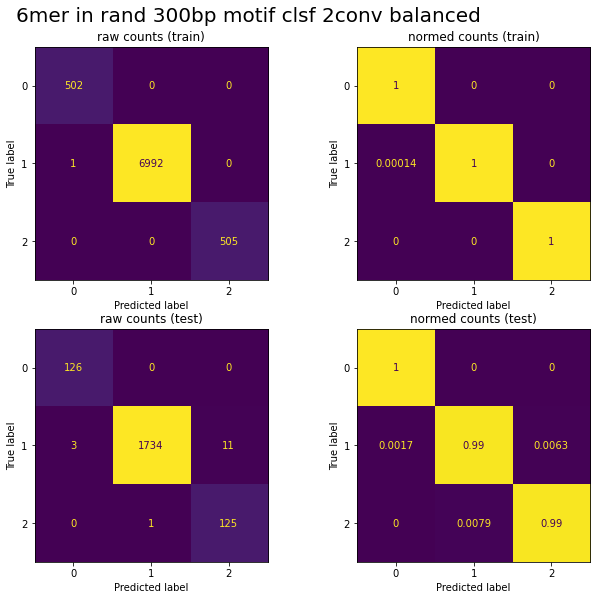

In [45]:
# Model set up
cnn7_name = "6mer in rand 300bp motif clsf 2conv balanced"
model7 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

# Model training
model_res[cnn7_name] = tu.collect_model_stats(
    cnn7_name,
    seq_len,
    syn_ohe_train_dl, # synthetic sequence DataLoader
    syn_ohe_val_dl, # synthetic sequence DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model7,
    loss_type='classification'
)

# Model evaluation
pred_dfs[cnn7_name] = tu.get_confusion_stats(
    model_res[cnn7_name]['model'],
    model_res[cnn7_name]['model_name'],
    syn_seq_list,
    DEVICE,
    title=f"{model_res[cnn7_name]['model_name']}"
)

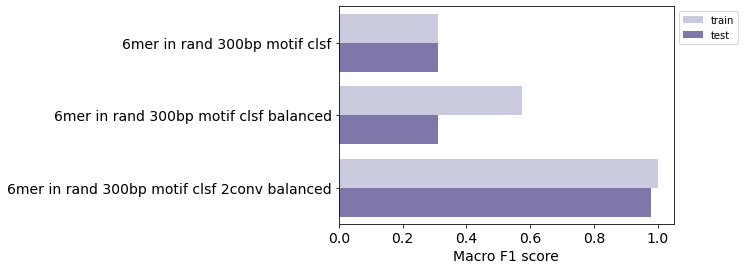

In [46]:
syn_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'rand' in x])
syn_preds

sns.barplot(data=syn_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

Ok so this pretty much worked! It's not perfect but the Mac F1 is actually quite good!

Let's peek at the filters this model learned. 

Total convolutional layers: 2
Num filters 8
filt_width 6
Seq 0 of 1000
Seq 100 of 1000
Seq 200 of 1000
Seq 300 of 1000
Seq 400 of 1000
Seq 500 of 1000
Seq 600 of 1000
Seq 700 of 1000
Seq 800 of 1000
Seq 900 of 1000
torch.Size([8, 4, 6])


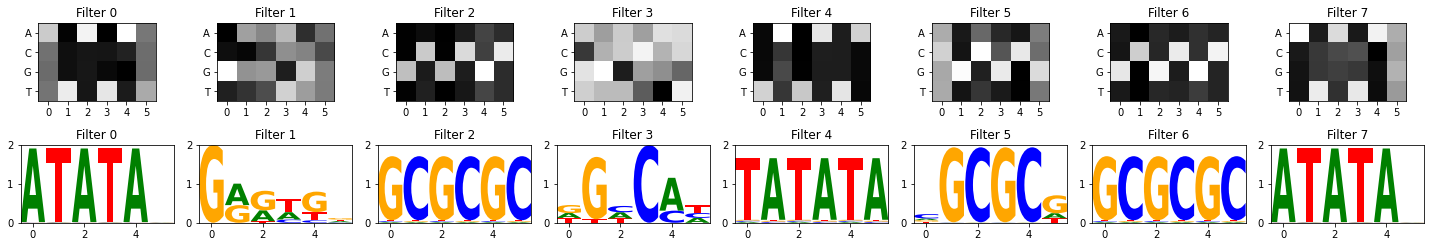

In [47]:
# Check filters of Model 7
seqs = syn_train_df['seq'].values[:1000] # take the first 1000 examples to generate filter activations
v.view_conv2D_wrapper(model7,seqs,DEVICE,act_thresh=0.5,ysc=0.25)

So is the answer just that we needed a more complex model for a more complex task?

Let's retry the 2-conv layer model with the original 2K _M. buryatense_ promoter sequences

## Train 2-conv layer model on _M. buryatense_ promoter regions

E:126 | train loss:0.741 | val loss: 1.062:   3%|▎         | 127/5000 [00:13<08:51,  9.17it/s]

EarlyStopping counter: 125 out of 500


E:251 | train loss:0.525 | val loss: 0.835:   5%|▌         | 252/5000 [00:27<08:36,  9.19it/s]

EarlyStopping counter: 250 out of 500


E:1157 | train loss:0.228 | val loss: 0.645:  23%|██▎       | 1158/5000 [02:06<06:56,  9.23it/s]

EarlyStopping counter: 125 out of 500


E:1395 | train loss:0.216 | val loss: 0.645:  28%|██▊       | 1396/5000 [02:31<06:30,  9.23it/s]

EarlyStopping counter: 125 out of 500


E:1520 | train loss:0.205 | val loss: 0.656:  30%|███       | 1521/5000 [02:45<06:19,  9.18it/s]

EarlyStopping counter: 250 out of 500


E:1645 | train loss:0.196 | val loss: 0.656:  33%|███▎      | 1646/5000 [02:59<06:04,  9.21it/s]

EarlyStopping counter: 375 out of 500


E:1769 | train loss:0.207 | val loss: 0.658:  35%|███▌      | 1769/5000 [03:12<05:51,  9.19it/s]


EarlyStopping counter: 500 out of 500
Early stopping


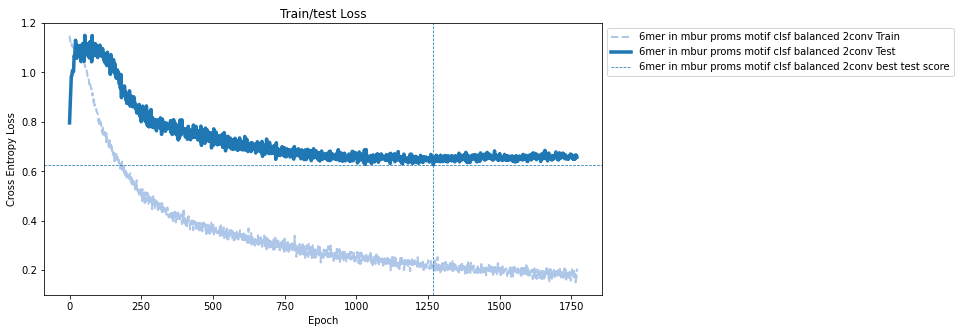

Running predictions for 6mer in mbur proms motif clsf balanced 2conv


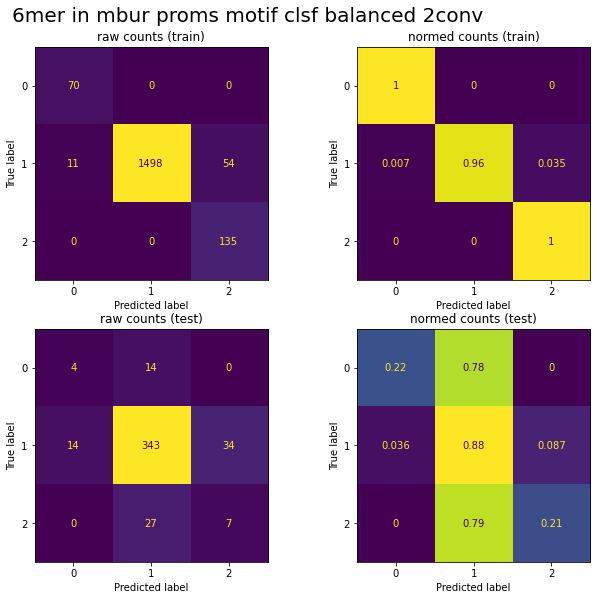

In [48]:
model8 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=3,
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=10,
)

cnn8_name = "6mer in mbur proms motif clsf balanced 2conv"

model_res[cnn8_name] = tu.collect_model_stats(
    cnn8_name,
    seq_len,
    ohe_train_dl, # M. buryatense DataLoader
    ohe_val_dl, # M. buryatense DataLoader
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model8,
    loss_type='classification'
)

pred_dfs[cnn8_name] = tu.get_confusion_stats(
    model_res[cnn8_name]['model'],
    model_res[cnn8_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn8_name]['model_name']}"
)

From this set of confusion matrices, it appears that the 2-conv layer model was not enough to fix the overfitting we saw with the smaller _M. buryatense_ promoter dataset, though from the barplot summary below, it did seem to help a little in terms of the Macro F1 score. 

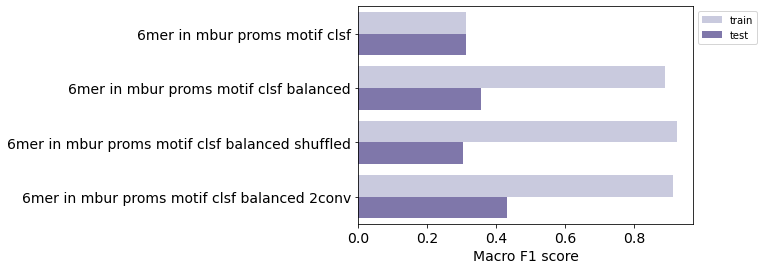

In [49]:
mbur_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'mbur' in x])
mbur_preds

sns.barplot(data=mbur_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()


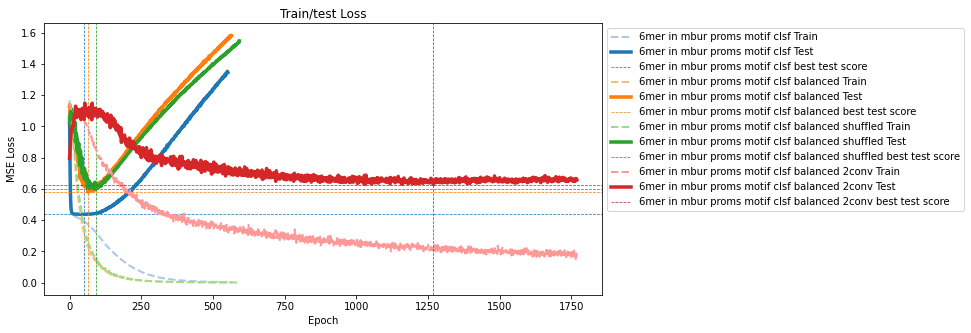

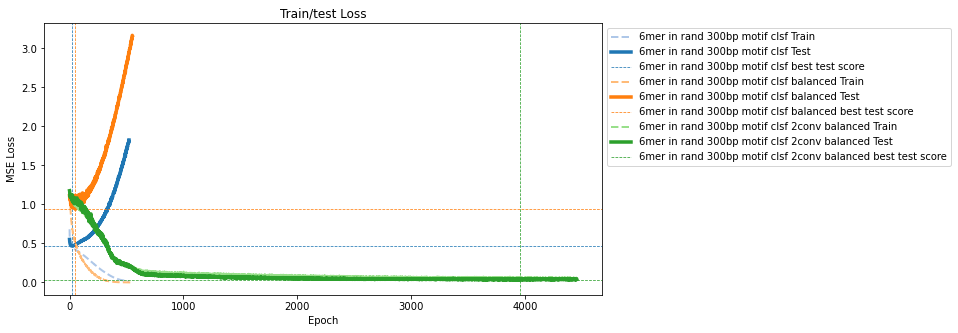

In [50]:
# All loss curves for models using M. buryatense sequences
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'mbur' in x])

# All loss curves for models using the ranomdly generated sequences
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res if 'rand' in x])

## Summary so far
The models with 2-conv layers seemed to help a little on the _M. buryatense_ sequences, but didn't fix the training as it did for the 10K random sequence dataset.

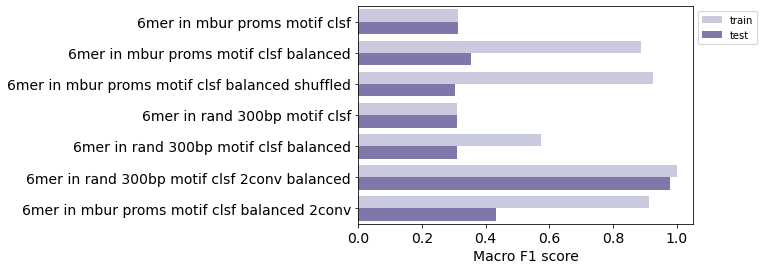

In [52]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

It seems like there's a few different dimensions to play with here:
* How many total sequences are there? (affects total training examples)
* How long are the sequences? (affects the signal to noise ratio of the 6-mer)
* How complex is the model?

For the next analyses, we left Jupyter Notebooks and wrote a script to loop through a few modeling parameters and ran it on UW's high performance computing cluster. Below we visualize the results from the result files generated from these scripts.

# Summary of model performances across different dataset sizes, sequence lengths, and model architectures.

Varied:
* Model arch: Simple CNN, 2Conv CNN, 2Conv CNN with Pooling
* Number of training seqs: 2K, 6K, 10K
* Length of sequence: 50bp, 150bp, 300bp
* Ran 5 folds for each level

After running a number of combinations of each of these levers in `synth_classification_randomseqs.py`, and collecting the results in `out_synth_cls/synth_cls_result_df.tsv`, here are some summary plots.

In [53]:
# dataframe of all the modeling results
df = pd.read_csv('out_synth_cls/synth_cls_result_df.tsv',sep='\t')
df

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,CNN_simple_fold1_300bp_10000seqs,train,0.645383,0.942404,0.724316,8000,CNN_simple,10000,300,1,0.904715,173,136.595901
1,CNN_simple_fold1_300bp_10000seqs,test,0.328935,0.325420,0.317209,2000,CNN_simple,10000,300,1,0.904715,173,136.595901
2,2CNN_fold2_50bp_10000seqs,train,0.984674,0.999830,0.992072,8000,2CNN,10000,50,2,0.033585,1389,420.815815
3,2CNN_fold2_50bp_10000seqs,test,0.933013,0.916613,0.924589,2000,2CNN,10000,50,2,0.033585,1389,420.815815
4,CNN_simple_fold3_300bp_10000seqs,train,0.498562,0.774438,0.530756,8000,CNN_simple,10000,300,3,0.948965,45,114.912976
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2CNN_pool_fold1_50bp_2000seqs,test,0.437676,0.395737,0.411146,400,2CNN_pool,2000,50,1,0.179892,1662,99.021336
266,CNN_simple_fold2_50bp_2000seqs,train,0.718008,0.994679,0.817854,1600,CNN_simple,2000,50,2,0.255622,349,31.229858
267,CNN_simple_fold2_50bp_2000seqs,test,0.325459,0.317136,0.321244,400,CNN_simple,2000,50,2,0.255622,349,31.229858
268,2CNN_fold2_150bp_10000seqs,train,1.000000,1.000000,1.000000,8000,2CNN,10000,150,2,0.150642,4510,1265.730436


In [54]:
# pull out results from just the test splits
df_test = df[df['split']=='test']

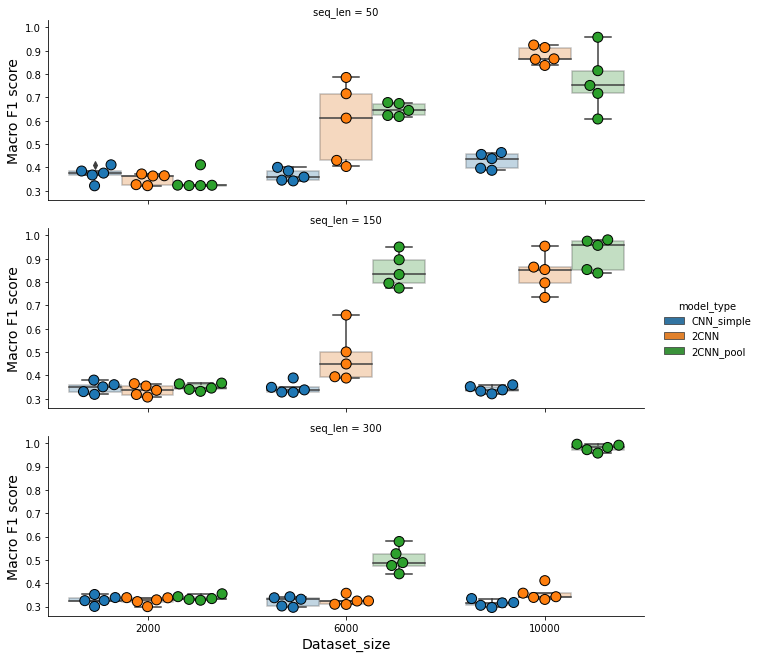

In [55]:
# Summary plot v1
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=10, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Dataset_size",fontsize=14)

plt.show()



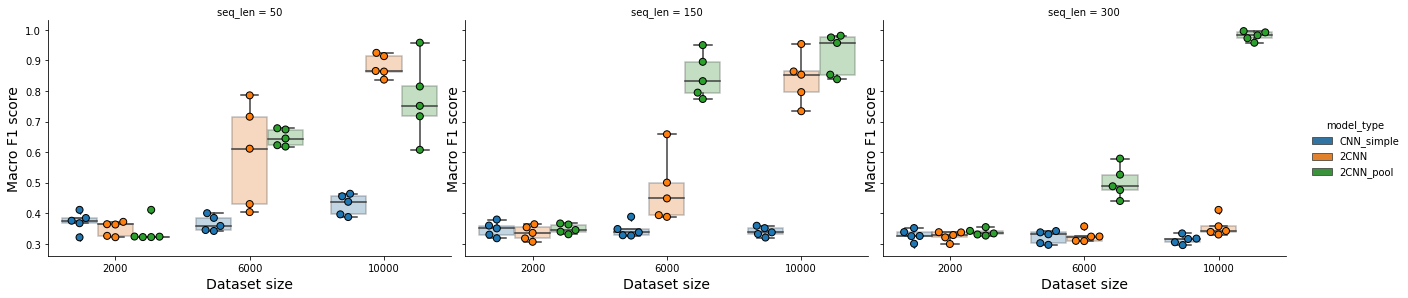

In [56]:
# Summary plot v2, 
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    col='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')
for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.show()



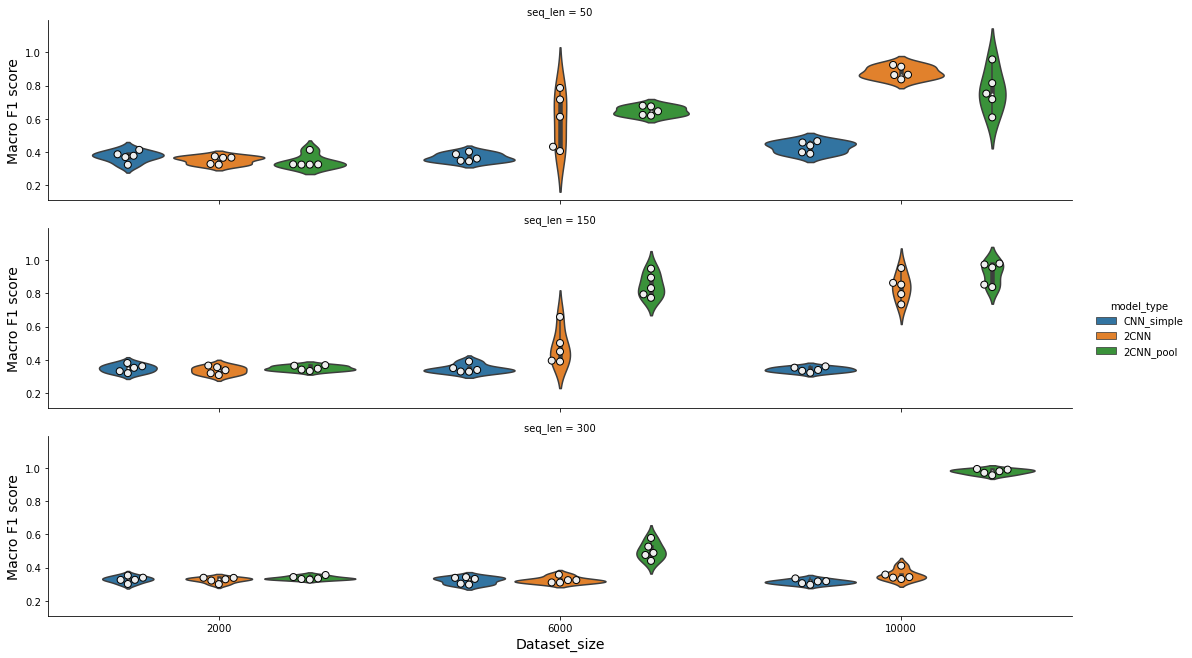

In [57]:
# Summary plot v3
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    row='seq_len', kind='violin',hue='model_type',
    hue_order=order,
    alpha=.3,height=3,aspect=10/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette=['#eeee'])

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Dataset_size",fontsize=14)
#plt.ylim(0,1)
plt.show()



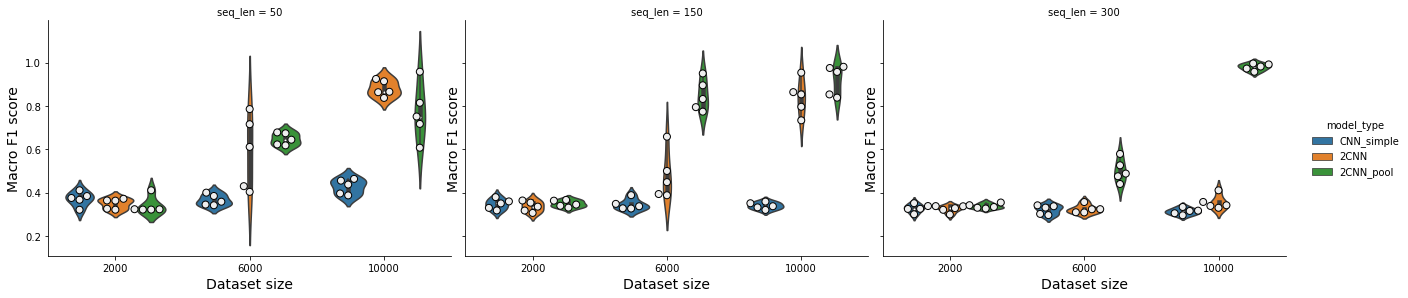

In [58]:
# Summary plot v4
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='mac_f1',
    col='seq_len', kind='violin',hue='model_type',
    hue_order=order,
    alpha=.3,height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='mac_f1',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette=['#eeee'])

for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
#plt.ylim(0,1)
plt.show()


### Quick plot of model run time instead of performance

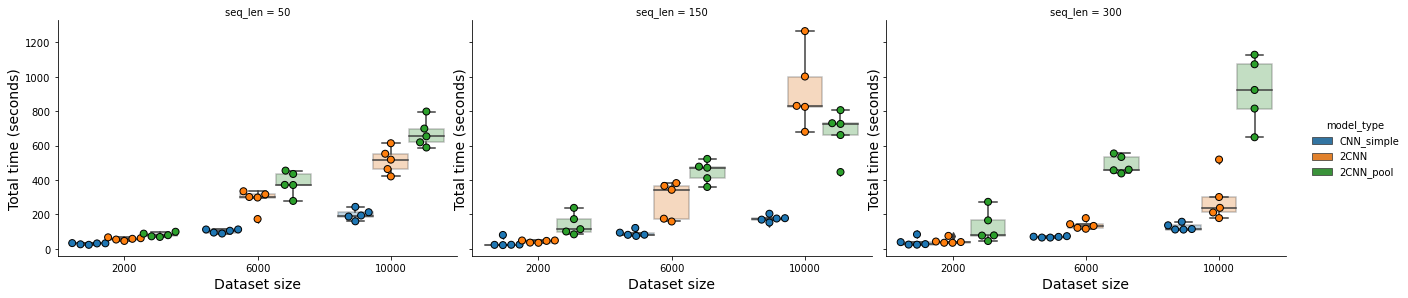

In [59]:
order = ['CNN_simple','2CNN','2CNN_pool']

g = sns.catplot(
    data=df_test, x='ds_size', y='total_time',
    col='seq_len', kind='box',hue='model_type',
    hue_order=order,
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='ds_size', y='total_time',
                hue='model_type',size=7, 
                hue_order=order,
                edgecolor='black',linewidth=1, dodge=True,palette='tab10')
for ax in g.axes.flatten():
    ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Total time (seconds)', fontsize=14)

plt.show()



Summary plot v2 is my favorite - it most clearly allows the viewer to compare performance across all the model parameter combos. 

In the 300bp window datasets, only the 2CNN_pool model seemed to work very well. But when the sequence lengths got shorter (150bp and 50bp), the 2CNN (no pool) did a bit better, and even at smaller overall datasets. 

However, something that stuck out as odd was that the same model architectures for the 50bp datasets should have had equally good performance as the 300bp datasets, if not _better_ since the signal should have been more dense in the 50bp and therefore easier to find. (The datasets with longer sequences had more "non-signal" bases that were not contributing to the classification signal.)

We realized that in these modeling runs, we did not explicity control for class-imbalance. The chance that a given 6-mer motif randomly shows up in a sequence of length 50 is much lower than the chance it happens to appear in a sequence of length 300. So the class imbalance was more severe for the shorter-sequence datasets. 

As a follow up analysis, we controlled for class imbalance by enforcing that each dataset had a specified number of examples from each minority class. This made the performances more comparable. We also zoomed in on datasets between 50 to 150 bases and took more granular steps in the dataset size parameter (increase by 10bp at a time). 

# Summary of model performances across a 10bp ladder of sequence lengths

Varied:
* Model arch: Simple CNN, 2Conv CNN, 2Conv CNN with Pooling
* `N` (number of training seqs): 2K, 6K, 10K
* `L` (length of sequence): 20bp-150bp
* `P` (Prevalence of Minority Class): 0.05, 0.01
* Ran 5 folds for each level

After running a number of combinations of each of these levers in `synth_classification_randomseqs.py`, and collecting the results in `out_synth_cls/synth_cls_10bp_ladder_[P]b_result_df.tsv`, here are some summary plots.

In [60]:
# Used this cell to compile results from several tsvs into one for use here
# from os import listdir

# dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.05b/'
# #dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.01b/'
# filenames = listdir(dirname)
# tsvs = [filename for filename in filenames if (filename.endswith('.tsv') and filename != 'all_pred_res.tsv')]

# df5 = pd.DataFrame()
# for f in tsvs:
#     df_new = pd.read_csv(f'{dirname}/{f}',sep='\t')
#     df5 = pd.concat([df5,df_new])

# df5.to_csv("out_synth_cls/synth_cls_10bp_ladder_0.05b_result_df.tsv")

In [62]:
# load results for 0.05 balance:
df5 = pd.read_csv('out_synth_cls/synth_cls_10bp_ladder_0.05b_result_df.tsv')
df5

,Unnamed: 0,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,0,2CNN_pool_fold2_90bp_10000seqs,train,0.993510,0.999628,0.996549,8000,2CNN_pool,10000,90,2,0.011845,4458,1088.099841
1,1,2CNN_pool_fold2_90bp_10000seqs,test,0.996262,0.993148,0.994696,2000,2CNN_pool,10000,90,2,0.011845,4458,1088.099841
2,0,2CNN_pool_fold1_120bp_10000seqs,train,0.991933,0.999535,0.995700,8000,2CNN_pool,10000,120,1,0.026842,2567,691.861686
3,1,2CNN_pool_fold1_120bp_10000seqs,test,0.983596,0.992650,0.988052,2000,2CNN_pool,10000,120,1,0.026842,2567,691.861686
4,0,2CNN_pool_fold0_90bp_10000seqs,train,0.980295,0.998839,0.989418,8000,2CNN_pool,10000,90,0,0.032217,1949,538.800429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,2CNN_pool_fold2_70bp_10000seqs,test,0.936113,0.989164,0.960244,2000,2CNN_pool,10000,70,2,0.031678,4020,990.646067
416,0,2CNN_pool_fold2_40bp_2000seqs,train,0.878524,0.990877,0.928549,1600,2CNN_pool,2000,40,2,0.101268,3149,186.606871
417,1,2CNN_pool_fold2_40bp_2000seqs,test,0.834414,0.970225,0.891956,400,2CNN_pool,2000,40,2,0.101268,3149,186.606871
418,0,2CNN_pool_fold3_130bp_10000seqs,train,1.000000,1.000000,1.000000,8000,2CNN_pool,10000,130,3,0.010682,1982,565.238792


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


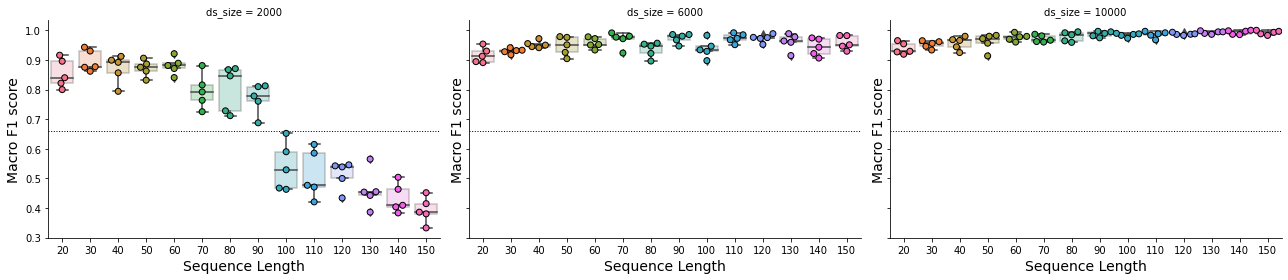

In [64]:
# Summary plot b05 v1
df5_test = df5[df5['split']=='test']

g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.tight_layout()
plt.savefig('img/10bp_ladder_b0.05.png', dpi=300)
plt.show()



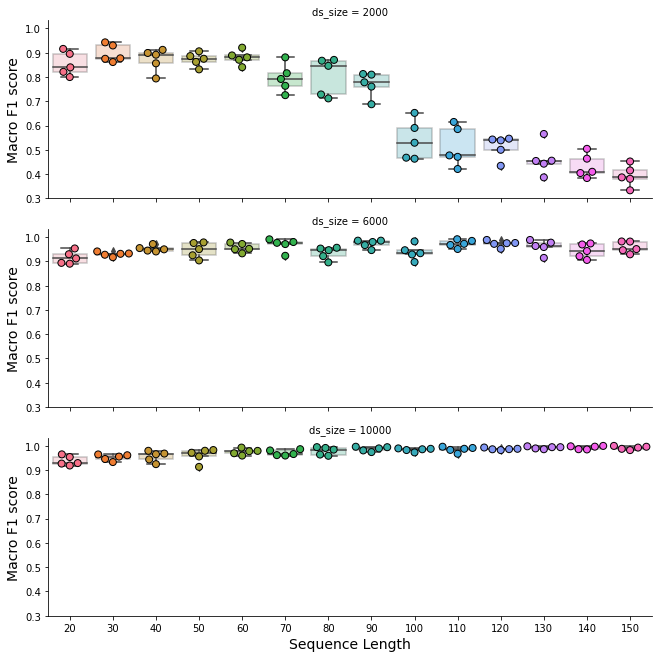

In [65]:
# Summary plot b05 v2
g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    row='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)
g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=7, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Sequence Length",fontsize=14)

plt.show()



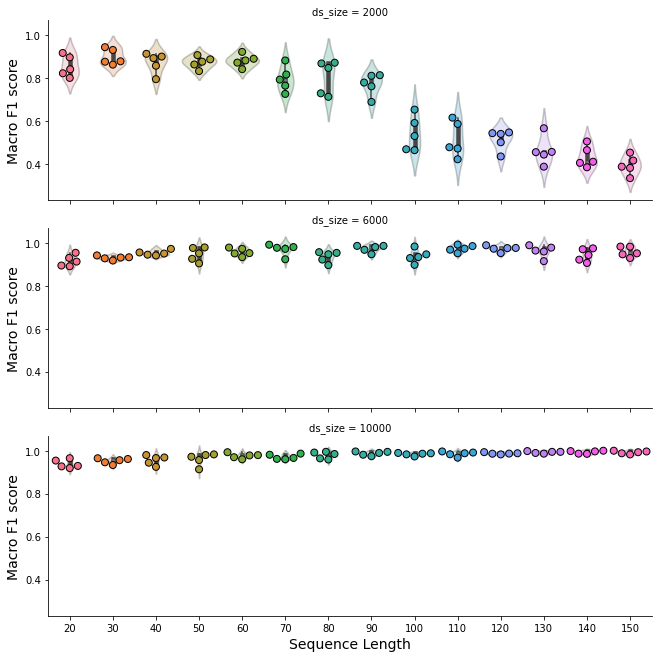

In [70]:
# Summary plot b05 v3
g = sns.catplot(
    data=df5_test, x='seq_len', y='mac_f1',
    row='ds_size', kind='violin',
    boxprops=dict(alpha=.3),height=3,aspect=6/2
)

for ax in g.axes.flatten():
    plt.setp(ax.collections,alpha=0.3)
    
g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=7, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.xlabel("Sequence Length",fontsize=14)

plt.show()



Models trained on these synthetic datasets showed performance trends consistent with the hypothesis that if the motif prevalence and total training examples are kept equal, models perform better when the signal density is higher (shorter sequence windows) This trend is demonstrated most clearly in the 2000 seq dataset models, which start to steeply drop in performance. When the minority class if balanced at 0.05, both the 6000 and 10,000 seq datasets perform well in all sequence lengths.

## Check out balanced at 1% results

In [71]:
# dirname = '../hyak_scp_dump/out_synth_cls_10bp_ladder_0.01b/'
# filenames = listdir(dirname)
# tsvs = [filename for filename in filenames if (filename.endswith('.tsv') and filename != 'all_pred_res.tsv')]

# df1 = pd.DataFrame()
# for f in tsvs:
#     df_new = pd.read_csv(f'{dirname}/{f}',sep='\t')
#     df1 = pd.concat([df1,df_new])

# df1.to_csv("out_synth_cls/synth_cls_10bp_ladder_0.01b_result_df.tsv")

# load results for 0.01 balance:
df1 = pd.read_csv('out_synth_cls/synth_cls_10bp_ladder_0.01b_result_df.tsv')
df1

,Unnamed: 0,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time
0,0,2CNN_pool_fold2_90bp_10000seqs,train,0.938123,0.998810,0.966958,4928,2CNN_pool,10000,90,2,0.114929,3190,486.957170
1,1,2CNN_pool_fold2_90bp_10000seqs,test,0.671568,0.718365,0.691564,1233,2CNN_pool,10000,90,2,0.114929,3190,486.957170
2,0,2CNN_pool_fold1_120bp_10000seqs,train,0.844784,0.995441,0.908757,4495,2CNN_pool,10000,120,1,0.233685,1242,215.330512
3,1,2CNN_pool_fold1_120bp_10000seqs,test,0.482894,0.457090,0.465844,1124,2CNN_pool,10000,120,1,0.233685,1242,215.330512
4,0,2CNN_pool_fold0_90bp_10000seqs,train,0.935290,0.998740,0.965304,4928,2CNN_pool,10000,90,0,0.116018,2269,364.440206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,2CNN_pool_fold2_70bp_10000seqs,test,0.687033,0.859813,0.755626,1503,2CNN_pool,10000,70,2,0.072667,2707,494.459997
416,0,2CNN_pool_fold2_40bp_2000seqs,train,0.793210,0.995930,0.874576,1600,2CNN_pool,2000,40,2,0.115473,893,66.692752
417,1,2CNN_pool_fold2_40bp_2000seqs,test,0.528139,0.598574,0.557380,400,2CNN_pool,2000,40,2,0.115473,893,66.692752
418,0,2CNN_pool_fold3_130bp_10000seqs,train,0.864872,0.996724,0.923133,4965,2CNN_pool,10000,130,3,0.234985,1562,278.536349


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


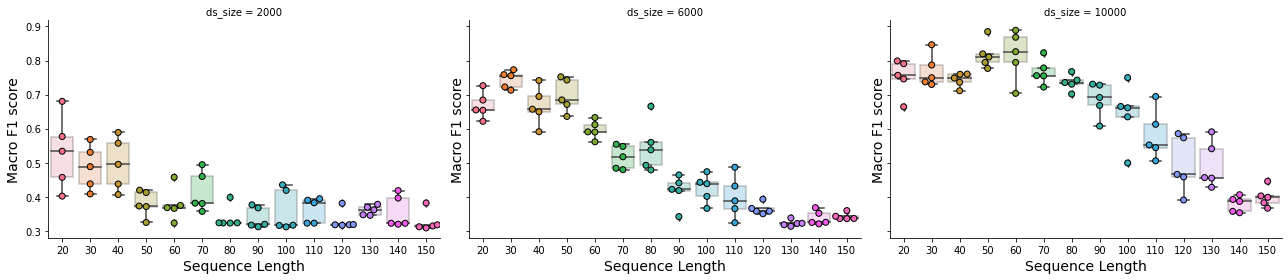

In [72]:
# Summary plot b01 v1
df1_test = df1[df1['split']=='test']

g = sns.catplot(
    data=df1_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')
for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.tight_layout()
plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()




/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


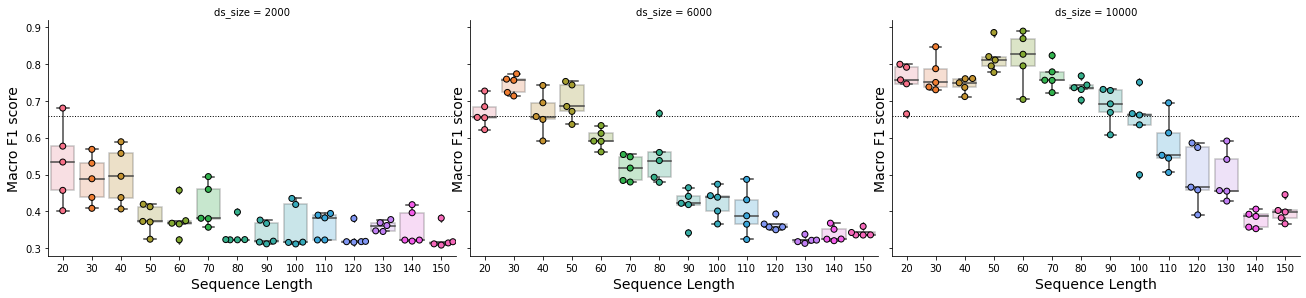

In [73]:
# Summary plot b01 v2

g = sns.catplot(
    data=df1_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6, 
                edgecolor='black',linewidth=1, dodge=True,palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

# plt.tight_layout()
# plt.savefig('img/10bp_ladder_b0.01.png', dpi=300)
plt.show()


The performance drop is demonstrated more clearly when the class balance is only at 0.01 (instead of 0.05, as above). With the more severe imbalance, even the 10,000 seq datasets can't perform well when the sequence windows are long. 

Intriguingly, there is high similarity between the trends in the panel for `P = 0.05, N = 2000` and `P = 0.01, N = 10000` where the total number of motif-containing example sequences is the same: 5% of 2,000 sequences and 1% of 10,000 sequences both equal 100. 

Here they are side by side

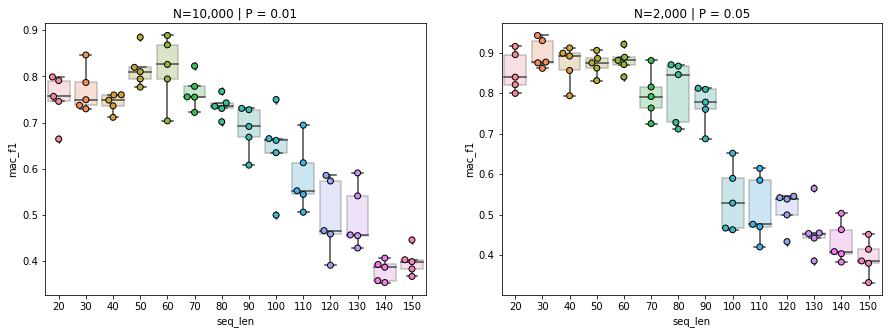

In [93]:
# Show 10K, 0.01 and 2K, 0.05 side by side
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

# 10K, 0.01
df1_10k = df1_test[df1_test['ds_size']==10000] 

sns.boxplot(ax=ax1,data=df1_10k, x='seq_len', y='mac_f1',boxprops=dict(alpha=0.3))
sns.swarmplot(ax=ax1,data=df1_10k, x='seq_len', y='mac_f1',edgecolor='black',linewidth=1,size=6)
ax1.set_title("N=10,000 | P = 0.01")

# 2K, 0.05
df5_2k = df5_test[df5_test['ds_size']==2000] 

sns.boxplot(ax=ax2,data=df5_2k, x='seq_len', y='mac_f1',boxprops=dict(alpha=0.3))
sns.swarmplot(ax=ax2,data=df5_2k, x='seq_len', y='mac_f1',edgecolor='black',linewidth=1,size=6)
ax2.set_title("N=2,000 | P = 0.05")

plt.show()

We also plot the rest of the panels together to make their trends across motif prevalences a bit more comparable. 

In [143]:
# merge both prevalence dfs into the same one
df1_test['motif_prev'] = 0.01
df5_test['motif_prev'] = 0.05

df15_test = pd.concat([df1_test,df5_test])
df15_test 

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,ds_size,seq_len,fold,best_val_score,epoch_stop,total_time,motif_prev
1,1,2CNN_pool_fold2_90bp_10000seqs,test,0.671568,0.718365,0.691564,1233,2CNN_pool,10000,90,2,0.114929,3190,486.957170,0.01
3,1,2CNN_pool_fold1_120bp_10000seqs,test,0.482894,0.457090,0.465844,1124,2CNN_pool,10000,120,1,0.233685,1242,215.330512,0.01
5,1,2CNN_pool_fold0_90bp_10000seqs,test,0.628140,0.731557,0.668362,1233,2CNN_pool,10000,90,0,0.116018,2269,364.440206,0.01
7,1,2CNN_pool_fold2_130bp_10000seqs,test,0.581816,0.600892,0.590811,1242,2CNN_pool,10000,130,2,0.159748,1906,325.477430,0.01
9,1,2CNN_pool_fold0_40bp_10000seqs,test,0.610760,0.958138,0.711316,2000,2CNN_pool,10000,40,0,0.072572,3468,880.892000,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,1,2CNN_pool_fold3_40bp_2000seqs,test,0.843762,0.971161,0.899057,400,2CNN_pool,2000,40,3,0.090778,2032,129.011086,0.05
413,1,2CNN_pool_fold0_30bp_2000seqs,test,0.841439,0.923779,0.877008,400,2CNN_pool,2000,30,0,0.125616,3243,215.945028,0.05
415,1,2CNN_pool_fold2_70bp_10000seqs,test,0.936113,0.989164,0.960244,2000,2CNN_pool,10000,70,2,0.031678,4020,990.646067,0.05
417,1,2CNN_pool_fold2_40bp_2000seqs,test,0.834414,0.970225,0.891956,400,2CNN_pool,2000,40,2,0.101268,3149,186.606871,0.05


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/e

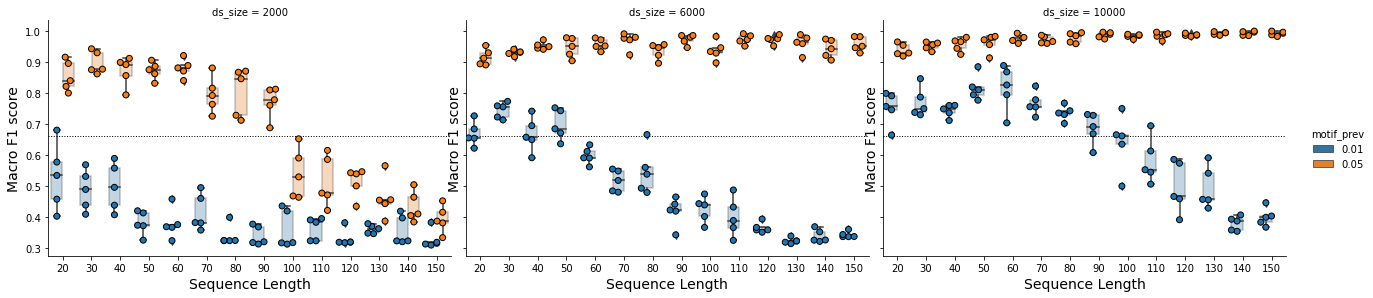

In [149]:
g = sns.catplot(
    data=df15_test, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',hue='motif_prev',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=6,
                edgecolor='black',linewidth=1, dodge=True,
                hue='motif_prev',palette='tab10')#palette='husl')

#g.refline(x=0.66)
g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)


plt.show()

Plot just the average across 5 folds

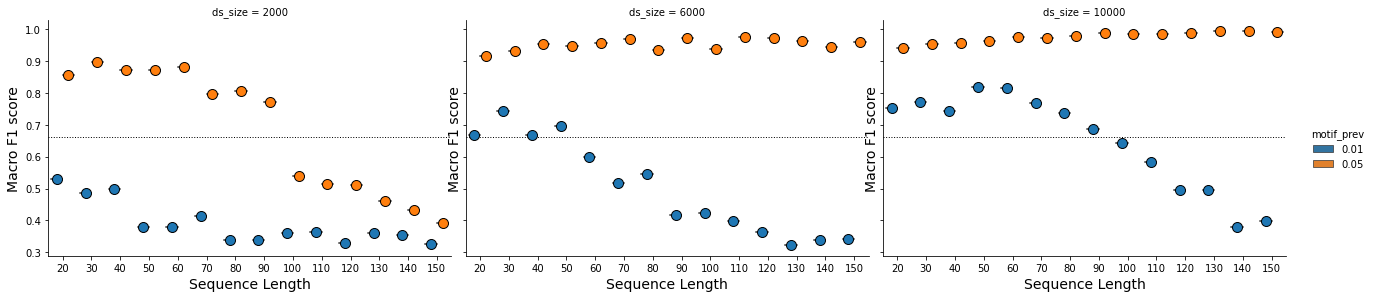

In [158]:
# group merge df and average over folds
gdf = df15_test.groupby(['seq_len','motif_prev','ds_size'],as_index=False).mean()

g = sns.catplot(
    data=gdf, x='seq_len', y='mac_f1',
    col='ds_size', kind='box',hue='motif_prev',
    boxprops=dict(alpha=.3),height=4,aspect=3/2
)

g.map_dataframe(sns.swarmplot, x='seq_len', y='mac_f1',
                size=10,edgecolor='black',linewidth=1, dodge=True,
                hue='motif_prev',palette='tab10')#palette='husl')

g.map(plt.axhline, y=0.66, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('Sequence Length', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)

plt.show()

Looking through these plots prompted us to consider if there exists a relationship between the “information richness” of the dataset and model performance that remains consistent across synthetic datasets.

# What is the "Information Richness" of each dataset?
To calculate the information richness in each dataset, we multiplied the motif signal density (motif length `6` divided by sequence length `L`), the motif prevalence `P` (fraction of training data containing the motif), and the dataset size`N`.

`data_info_richness = motif_len/L * P * N`

* `motif_len` = 6 (TATATA or GCGCGC)
* `N` = number of sequences in the dataset (2K, 6K, 10K)
* `L` = length of sequence window (20 - 150, steps of 10)
* `P` = prevalence of the minority classes (0.05, 0.01)

In [140]:
# Calculate the the information richness for each model setting
data = []
for seq_len in range(20,160,10):
    for motif_prev in [0.05,0.01]:
        for ds_size in [2000,6000,10000]:
#             signal = 6/seq_len
#             sig_perc = signal*motif_perc
#             example_perc = sig_perc*ds_size
#             print(f"{seq_len}|{motif_perc}|{ds_size}:\t{signal:.3f}\t{sig_perc:.5f}\t{example_perc:.5f}")
            info_rich = 6/seq_len * motif_prev * ds_size
            row = [seq_len,motif_prev,ds_size,info_rich]
            data.append(row)

sig_df = pd.DataFrame(data,columns=['seq_len','motif_prev','ds_size','info_rich'])
sig_df.head(10)

,seq_len,motif_prev,ds_size,info_rich
0,20,0.05,2000,30.0
1,20,0.05,6000,90.0
2,20,0.05,10000,150.0
3,20,0.01,2000,6.0
4,20,0.01,6000,18.0
5,20,0.01,10000,30.0
6,30,0.05,2000,20.0
7,30,0.05,6000,60.0
8,30,0.05,10000,100.0
9,30,0.01,2000,4.0


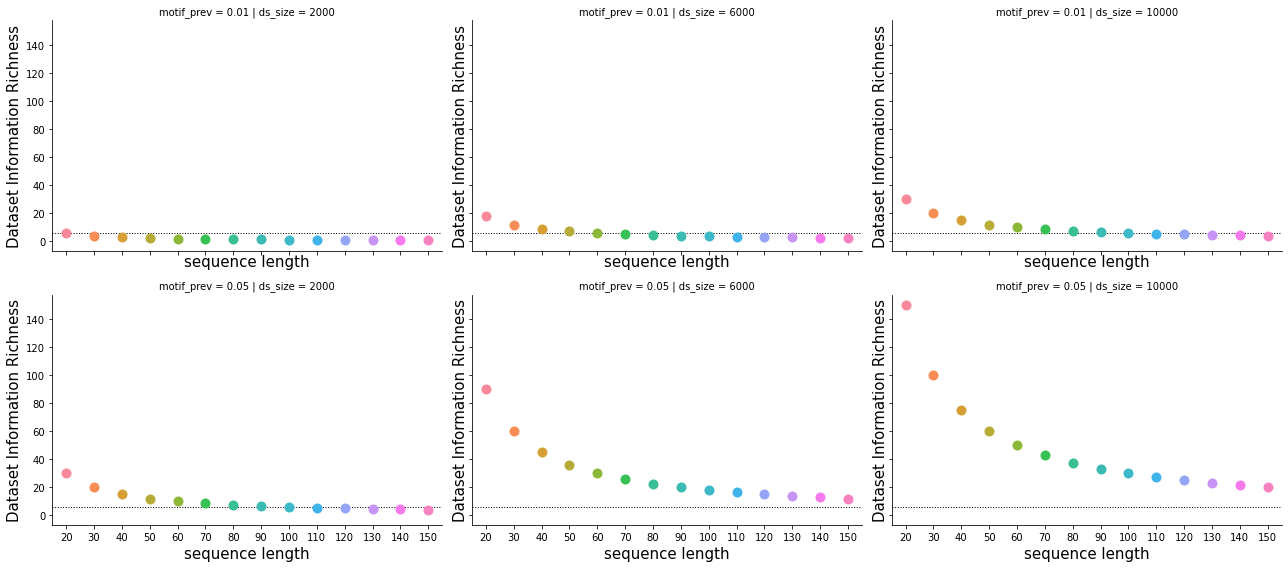

In [139]:
g = sns.catplot(
    data=sig_df, x='seq_len', y='info_rich',
    col='ds_size', kind='swarm',row='motif_prev',s=10,
    height=4,aspect=3/2
)

g.map(plt.axhline, y=6, ls='dotted', c='black',lw=1)

for ax in g.axes.flatten():
    ax.set_xlabel('sequence length', fontsize=15)
    ax.set_ylabel('Dataset Information Richness', fontsize=15)

plt.tight_layout()
plt.show()

Now instead of showing model performance, here's a plot showing the Information Richness of each of the datasets models were trained on. Expectedly, the most information richness is in the largest datasets with the higher motif prevalence, and the information richness drops from there.

# Is there a relationship between model performance and dataset information richness?
Next we combine our model performance data with the dataset information richness and plot them to investigate trends.

In [150]:
# merge the sig_df (info richness) with the test split model results (df15_test)
merge_df = pd.merge(sig_df,df15_test,how='left',on=['seq_len','ds_size','motif_prev'])
merge_df

,seq_len,motif_prev,ds_size,info_rich,Unnamed: 0,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
0,20,0.05,2000,30.0,1,2CNN_pool_fold0_20bp_2000seqs,test,0.791809,0.907315,0.839894,400,2CNN_pool,0,0.128454,2109,157.450184
1,20,0.05,2000,30.0,1,2CNN_pool_fold3_20bp_2000seqs,test,0.727299,0.928204,0.799817,400,2CNN_pool,3,0.202132,1919,127.422944
2,20,0.05,2000,30.0,1,2CNN_pool_fold2_20bp_2000seqs,test,0.755565,0.921487,0.821313,400,2CNN_pool,2,0.186953,4282,250.183475
3,20,0.05,2000,30.0,1,2CNN_pool_fold1_20bp_2000seqs,test,0.904616,0.931145,0.915869,400,2CNN_pool,1,0.065265,3960,232.221771
4,20,0.05,2000,30.0,1,2CNN_pool_fold4_20bp_2000seqs,test,0.836538,0.985994,0.895516,400,2CNN_pool,4,0.111056,4205,246.966098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,150,0.01,10000,4.0,1,2CNN_pool_fold1_150bp_10000seqs,test,0.392467,0.406602,0.398605,1289,2CNN_pool,1,0.295138,769,186.865866
416,150,0.01,10000,4.0,1,2CNN_pool_fold2_150bp_10000seqs,test,0.389916,0.379014,0.382724,1289,2CNN_pool,2,0.302105,1604,309.401212
417,150,0.01,10000,4.0,1,2CNN_pool_fold4_150bp_10000seqs,test,0.396723,0.410204,0.402665,1289,2CNN_pool,4,0.260451,643,169.660027
418,150,0.01,10000,4.0,1,2CNN_pool_fold3_150bp_10000seqs,test,0.436751,0.458478,0.445627,1289,2CNN_pool,3,0.263722,1470,289.015167


In [162]:
# get the means of the merged df with groupby
merge_gdf = merge_df.groupby(['seq_len','motif_prev','ds_size'],as_index=False).mean()
merge_gdf

,seq_len,motif_prev,ds_size,info_rich,Unnamed: 0,mac_precision,mac_recall,mac_f1,support,fold,best_val_score,epoch_stop,total_time
0,20,0.01,2000,6.0,1.0,0.496580,0.607051,0.530038,400.0,2.0,0.170716,1545.6,95.131109
1,20,0.01,6000,18.0,1.0,0.580254,0.872127,0.668192,1200.0,2.0,0.108236,2229.2,349.907681
2,20,0.01,10000,30.0,1.0,0.656617,0.945297,0.751287,2000.0,2.0,0.062944,3717.2,859.651554
3,20,0.05,2000,30.0,1.0,0.803165,0.934829,0.854482,400.0,2.0,0.138772,3295.0,202.848894
4,20,0.05,6000,90.0,1.0,0.870411,0.976738,0.916169,1200.0,2.0,0.076637,4483.6,637.157411
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,150,0.01,6000,2.4,1.0,0.341530,0.347453,0.342266,773.0,2.0,0.347293,796.8,117.291393
80,150,0.01,10000,4.0,1.0,0.395860,0.405751,0.399226,1289.0,2.0,0.281238,1111.0,237.092726
81,150,0.05,2000,4.0,1.0,0.394556,0.399287,0.393284,400.0,2.0,0.622536,1854.8,119.021450
82,150,0.05,6000,12.0,1.0,0.953841,0.964012,0.958233,1200.0,2.0,0.053464,3233.4,530.092575


In [163]:
folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

means = alt.Chart(merge_gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

folds+means

alt.LayerChart(...)

Plot showing the information richness on the x-axis and model performances on the y-axis. The solid/black outlined points are the means while the empty points are individual folds. Color is a spectrum of sequence lengths and shape is for the 3 different dataset sizes. 

The relationship between the information density for each dataset against the model performance on that dataset is somewhat sigmoidal. In particular, datasets with information density lower than ~6 seem to never perform much better than 0.6 F1-score in the classification task, regardless of the total dataset size. 

On the contrary, datasets with information density higher than 30 almost always perform better than 0.9 F1-score. 

### Separate the dataset sizes to use 3 different color spectrums

In [175]:
# indiv folds
sds_df = merge_df[merge_df['ds_size']==2000]
mds_df = merge_df[merge_df['ds_size']==6000]
lds_df = merge_df[merge_df['ds_size']==10000]

# means
sdsm_df = merge_gdf[merge_gdf['ds_size']==2000]
mdsm_df = merge_gdf[merge_gdf['ds_size']==6000]
ldsm_df = merge_gdf[merge_gdf['ds_size']==10000]

In [176]:
lds_df

,seq_len,motif_prev,ds_size,info_rich,Unnamed: 0,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,fold,best_val_score,epoch_stop,total_time
10,20,0.05,10000,150.0,1,2CNN_pool_fold3_20bp_10000seqs,test,0.881115,0.988500,0.929183,2000,2CNN_pool,3,0.054790,3891,952.751474
11,20,0.05,10000,150.0,1,2CNN_pool_fold2_20bp_10000seqs,test,0.929069,0.985174,0.954102,2000,2CNN_pool,2,0.042166,4231,1016.157101
12,20,0.05,10000,150.0,1,2CNN_pool_fold4_20bp_10000seqs,test,0.872417,0.977886,0.919144,2000,2CNN_pool,4,0.062988,3157,793.975244
13,20,0.05,10000,150.0,1,2CNN_pool_fold0_20bp_10000seqs,test,0.876675,0.991277,0.927038,2000,2CNN_pool,0,0.063325,1858,511.591306
14,20,0.05,10000,150.0,1,2CNN_pool_fold1_20bp_10000seqs,test,0.942504,0.990063,0.965090,2000,2CNN_pool,1,0.025192,4691,1076.240546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,150,0.01,10000,4.0,1,2CNN_pool_fold1_150bp_10000seqs,test,0.392467,0.406602,0.398605,1289,2CNN_pool,1,0.295138,769,186.865866
416,150,0.01,10000,4.0,1,2CNN_pool_fold2_150bp_10000seqs,test,0.389916,0.379014,0.382724,1289,2CNN_pool,2,0.302105,1604,309.401212
417,150,0.01,10000,4.0,1,2CNN_pool_fold4_150bp_10000seqs,test,0.396723,0.410204,0.402665,1289,2CNN_pool,4,0.260451,643,169.660027
418,150,0.01,10000,4.0,1,2CNN_pool_fold3_150bp_10000seqs,test,0.436751,0.458478,0.445627,1289,2CNN_pool,3,0.263722,1470,289.015167


In [180]:
op = 0.9 # opacity var
fig_dim = 600
point_size = 200

sds = alt.Chart(sdsm_df).mark_point(size=point_size,filled=True,opacity=op).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=fig_dim,
    height=fig_dim
)

mds = alt.Chart(mdsm_df).mark_point(size=point_size,filled=True,opacity=op).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='greens',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=fig_dim,
    height=fig_dim
)

lds = alt.Chart(ldsm_df).mark_point(size=point_size,filled=True,opacity=op).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=fig_dim,
    height=fig_dim
)

testm = mds + sds + lds
testm = testm.resolve_scale(color='independent')
testm.configure_axis(grid=False)

alt.LayerChart(...)

Here is a view where the dataset sizes are differentiated by color, the shape is the prevalence, and the color intensity is the sequence length. I think this is the easiest version in which to see the different trends but I explore a few other views below.

In [182]:
op = 0.9
filled=False
fig_dim = 400
point_size = 100

s5ds = alt.Chart(sds_df[sds_df['motif_prev']==0.05]).mark_point(size=point_size,filled=filled,opacity=op).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=fig_dim,
    height=fig_dim
)

l1ds = alt.Chart(lds_df[lds_df['motif_prev']==0.01]).mark_point(size=point_size,filled=filled,opacity=op).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=fig_dim,
    height=fig_dim
)

testx = s5ds + l1ds
testx = testx.resolve_scale(color='independent')
testx.configure_axis(grid=False)

alt.LayerChart(...)

As noted earlier, datasets of 2,000 sequences with 5% motif prevalence and datasets of 10,000 sequences with 1% motif prevalence contain the same total number of motif-containing example sequences. We saw these model performances within the range of sequence lengths explored track each other quite closely on the performance curve.

# Summary and some thoughts going forward

While we do see an interesting relationship between information richness and model performance on this synthetic task, we do not expect the specific parameters defined by this curve to be a formal “law” - it is likely that the observed shape is additionally influenced by other factors, such as the precise model architecture, the motif signal lengths, and the complexity of the activation and/or repression mechanism. 

Further investigations are warranted to gain a more complete picture of this relationship. However, what is clear from this analysis is that for a task as biologically simple as one activating motif and one repressing motif, searching through 300bp sequences for ~6bp signals with only 2,000 examples is very difficult using a common CNN architecture that has been successful on other gene expression prediction tasks, such as in DeepSea, Basset, and with MPRA data. Therefore, tasks that are more complex than a simple pair of activating and repressing motifs - which is most likely the case for true microbial genetic grammars - would be nearly impossible to predict in such a data-limited regime.

To tie this relationship back to our original copper prediction task for _M. buryatense_, we more precisely describe the promoter dataset with respect to these information richness levers. Due to the limits of this organism’s genome size and estimated operon membership, it contains only ~2,000 promoter region sequence examples (in `XY_df`). With transcription start site annotations available in other organisms such as E. coli, other CNN-based predictions efforts are able to use smaller sequence windows closer to 80-100bp. However, without such annotations available in _M. buryatense_, we use 300bp windows to ensure we do not fully miss the core promoter region, as the distance between the transcription and translation start sites can be variable within organisms. 

If the transcriptional activation or repression observed within _M. buryatense_ in response to copper is induced by a binding event, we can estimate a typical signal length between 6-12bp. Based on an upper and lower threshold cut off of 0.6 for the log ratio copper expression values, we assigned 145 sequences to the down-regulated class and 58 example sequences to the up-regulated class out of 2159 total, yielding an average motif prevalence of 0.046 between these two groups. 

Plugging these values into the information richness equation, we can estimate that the information richness with respect to copper response in the _M. buryatense_ dataset is between 1.98 and 3.97. In the over-simplified synthetic task explored in this notebook, datasets in similar regimes of information density typically achieved model performances between 0.3 - 0.4, which is similar performance to when models exclusively predict the majority class and ignore the minorities (macro-F1 score = 0.33 for three classes).

This suite of analyses help explain why our previously modeling efforts were so unproductive. While there exist other possible factors that may be contributing to poor prediction performance – perhaps the copper binding signal is not located within the typical boundaries of prokaryotic promoter regions or perhaps this response is not actually regulated by a binding event – if there is a signal to find, is it not likely for standard CNN models to capture it with the _M. buryatense_ dataset on its own given its limited information richness. We therefore conclude that incorporating additional data would be necessary to proceed with the prediction task, though it remains to be determined what additional data, if any, would be enough to improve predictive power.

### Further tinkering with altair visualizations

In [164]:
alt.hconcat(means,folds)

alt.HConcatChart(...)

Here is the plot with the means and the folds separated.

In [165]:
folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    row='ds_size:N',
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=100
)

means = alt.Chart(merge_gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    row='ds_size:N',
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=100
)

alt.hconcat(means,folds)

alt.HConcatChart(...)

Here, they are further separated by dataset type. The performance slowly snakes up the curve as the dataset size increases.

In [166]:
# folds = alt.Chart(merge_df).mark_point(size=60,opacity=0.5).encode(
#     x=alt.X('example_perc:Q',scale=alt.Scale(type='log')),
#     y=alt.Y('mac_f1:Q'),
#     shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
#     color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
#     column='motif_perc:N',
#     tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'signal:Q']
# ).interactive().properties(
#     width=300,
#     height=300
# )

means = alt.Chart(merge_gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    column='motif_prev:N',
    tooltip=['seq_len:Q', 'motif_perc:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

#folds+means
means

alt.Chart(...)

From this plot, we see the 0.05 prevalence datasets occupy the top end of the performance curve.

In [167]:
means = alt.Chart(merge_gdf).mark_point(size=80,filled=True,stroke="black").encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='plasma',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)
means

alt.Chart(...)

Here are the means but shaped by prevalence now. The squares (0.05) are mostly at the stop while the circles (0.01) are mostly at the bottom

In [177]:
sds = alt.Chart(sds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='oranges',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

mds = alt.Chart(mds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='greens',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

lds = alt.Chart(lds_df).mark_point(size=60,opacity=0.5).encode(
    x=alt.X('info_rich:Q',scale=alt.Scale(type='log')),
    y=alt.Y('mac_f1:Q'),
    #row='ds_size:N',
    #shape=alt.Shape('ds_size:O',scale=alt.Scale(range=['circle','triangle','square'])),
    shape=alt.Shape('motif_prev:O',scale=alt.Scale(range=['circle','square'])),
    color=alt.Color("seq_len:O",scale=alt.Scale(scheme='purples',reverse=True)),
    tooltip=['seq_len:Q', 'motif_prev:N', 'ds_size:N', 'info_rich:Q']
).interactive().properties(
    width=300,
    height=300
)

test = mds + sds + lds
test.resolve_scale(color='independent').configure_axis(grid=False)

alt.LayerChart(...)

Tri-color version but with all folds individually.

In [181]:
comb = test+testm
comb.resolve_scale(color='independent').configure_axis(grid=False)

alt.LayerChart(...)